In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mainData = pd.read_excel('Online Retail.xlsx')

In [3]:
mainData.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
mainData.dropna(inplace=True)

In [5]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [6]:
mainData['TransactionDate'] = mainData['InvoiceDate'].apply(lambda x: f'{x.year}-{x.month}-1')
mainData['TransactionDate'] = pd.to_datetime(mainData.TransactionDate)                                                     

In [7]:
CLVData=mainData[['CustomerID','InvoiceDate','Quantity','UnitPrice']].copy()

In [8]:
CLVData['Price']=CLVData.Quantity*CLVData.UnitPrice

In [9]:
CLVData['Date']=CLVData.InvoiceDate.apply(lambda x:f'{x.year}-{x.month}-{x.day}')
CLVData['Date']=pd.to_datetime(CLVData['Date'])

In [27]:
CLVData_Count=CLVData.sort_values(['CustomerID']).groupby('CustomerID').aggregate({'Price':{'sum','mean'},'Quantity':{'sum','mean'}}).set_axis(['Price_Sum','Price_Mean','Quantity_Average','Quantity_Sum'],axis=1)

In [28]:
Max_Date=CLVData.Date.max()
Recency_df=CLVData[['CustomerID','Date']].groupby('CustomerID').apply(lambda x: (x['Date'].max()-Max_Date)/pd.to_timedelta(1,unit='day')).to_frame().set_axis(['Recency'],axis=1)
Frequency_df=CLVData[['CustomerID','Date']].groupby('CustomerID').count().set_axis(['Frequency'],axis=1)

In [31]:
CLVData2=CLVData_Count.merge(Recency_df, right_index=True,left_index=True,how='left').fillna(0).merge(Frequency_df, right_index=True,left_index=True,how='left').fillna(0).reset_index()

In [41]:
CLVData2['Quantity_Average']=CLVData2.Quantity_Average.apply(lambda x: round(x))

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [42]:
scaler=MinMaxScaler()
scaler.fit(CLVData2[CLVData2.columns[1:]])

MinMaxScaler()

In [45]:
CLVData3=pd.DataFrame(scaler.transform(CLVData2[CLVData2.columns[1:]]))

In [47]:
CLVData3.columns=CLVData2.columns[1:]

In [81]:
App_PCA=PCA(n_components=2)
App_PCA.fit(CLVData3)

PCA(n_components=2)

In [82]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Elbow curve')

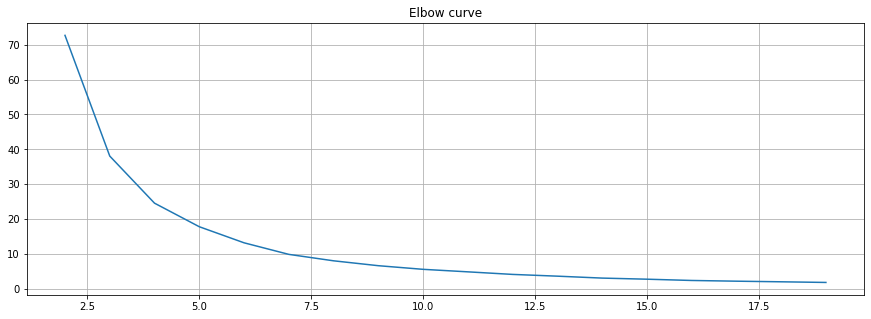

In [83]:

distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k,algorithm='elkan')
    kmeans.fit(App_PCA.transform(CLVData3))
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [87]:
kmeans = KMeans(n_clusters=5,algorithm='elkan').fit(App_PCA.transform(CLVData3))
CLVData2['Labels']=kmeans.labels_
CLVData3['Labels']=kmeans.labels_

In [90]:
import seaborn as sns

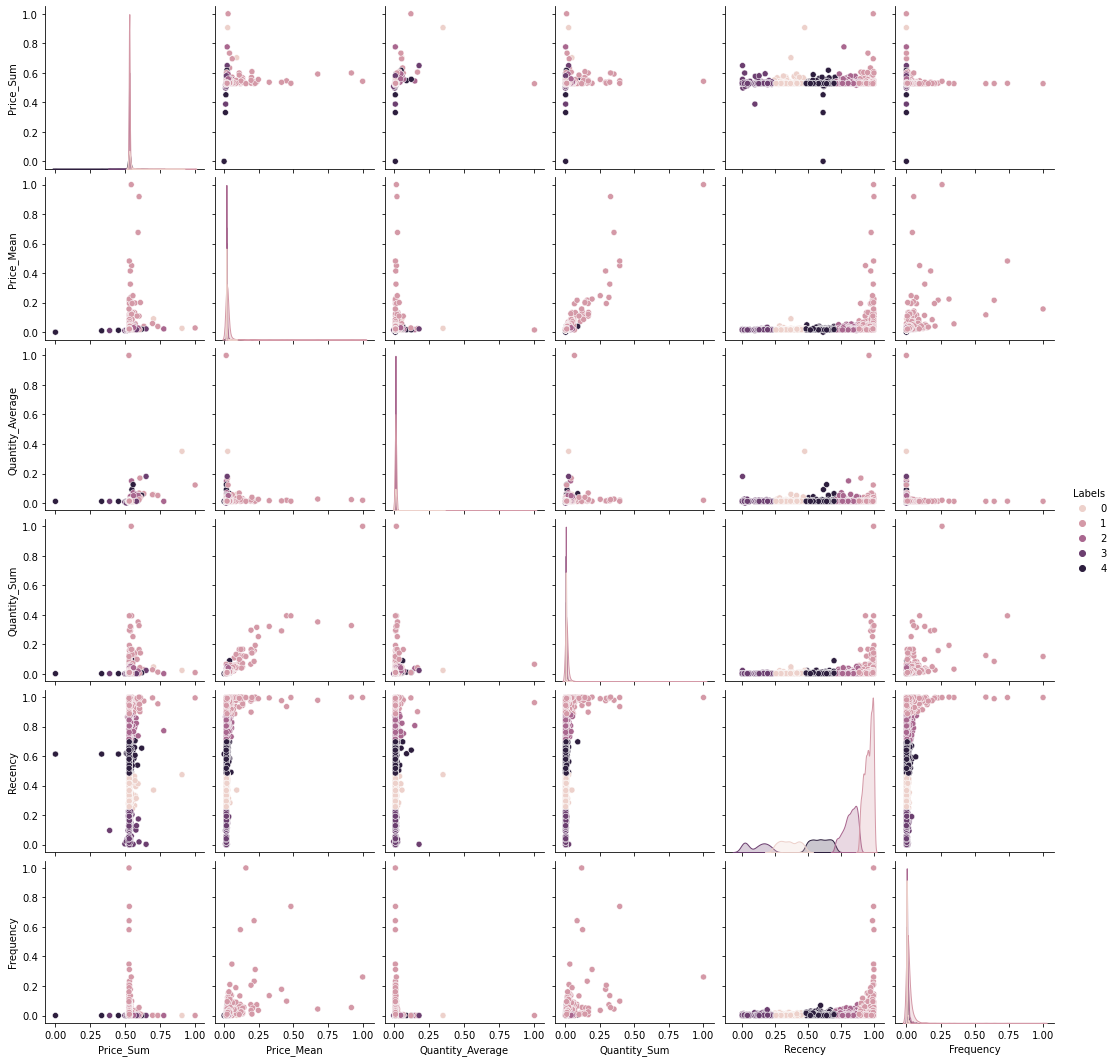

In [95]:
sns.pairplot(CLVData3,hue='Labels');

In [97]:
CLVData2[['CustomerID','Labels']].to_csv('Customer Segments.csv',index=False)